# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

*Matthew Backhouse, Monica Stephanie, Ross Campbell, Royce Yan*

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules that are necessary
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance

# Other modules that are necessary
from difflib import get_close_matches
from bs4 import BeautifulSoup
import re
import requests
import warnings

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')
%matplotlib inline

In [2]:
# Load data
data = pd.read_csv('the_office.csv')
data_guest_star = pd.read_csv('guest_duration_office.csv')

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1. Data Discovery
This subsection aims to provide a more comprehend view of **data** and **data_guest_star** using `describe_data` function. The objective of this section is to identify whether any data cleansing needs to be performed on the data, e.g., fixing typo, null values imputation, etc, before feeding it into the model.

In [3]:
def describe_data(data):
    """
    Provides the data structure, sample, descriptive statistics, and unique values of the data.
    This function aims to give insights about the content of the dataset and inform users whether any data
    cleansing process needs to be done.
    
    Parameters
    ----------
    data: Raw data (pandas.DataFrame)
    
    Raises
    ------
    KeyError raised if data is empty
    """
    
    data_length = len(data)
    
    # Raising errors if data is empty
    if data_length == 0:
        raise KeyError(f'Data is empty.')
    
    print('----- Data Structure -----')
    display(data.info())
    
    print('----- Descriptive Statistics -----')
    display(data.describe())
    
    print('----- Histogram & Boxplot -----')
    data_num = data.select_dtypes(include=['float64', 'int64'])
    fig, ax = plt.subplots(2, len(data_num.columns), figsize=(15,5))
    fig.tight_layout(w_pad=2, h_pad=2)
    for i, col in enumerate(data_num.columns):
        sns.histplot(data_num[col], ax=ax[0, i])
        sns.boxplot(data_num[col], ax=ax[1, i])
    plt.show()
    
    print('----- Unique Values -----')
    for col in data.columns:
        unique_vals = sorted(data[col].dropna().unique())
        length_unique_vals = len(unique_vals)
        
        if length_unique_vals <= data_length/3:
            print(f'{col} has {length_unique_vals} unique values: {unique_vals}\n')
        else:
            print(f'{col} has {length_unique_vals} unique values.\nFirst 3: {unique_vals[:3]}\nLast 3: {unique_vals[-3:]}\n')
            
    print('----- Sample: First 25 Rows -----')
    display(data.head(25))

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


None

----- Descriptive Statistics -----


,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000


----- Histogram & Boxplot -----


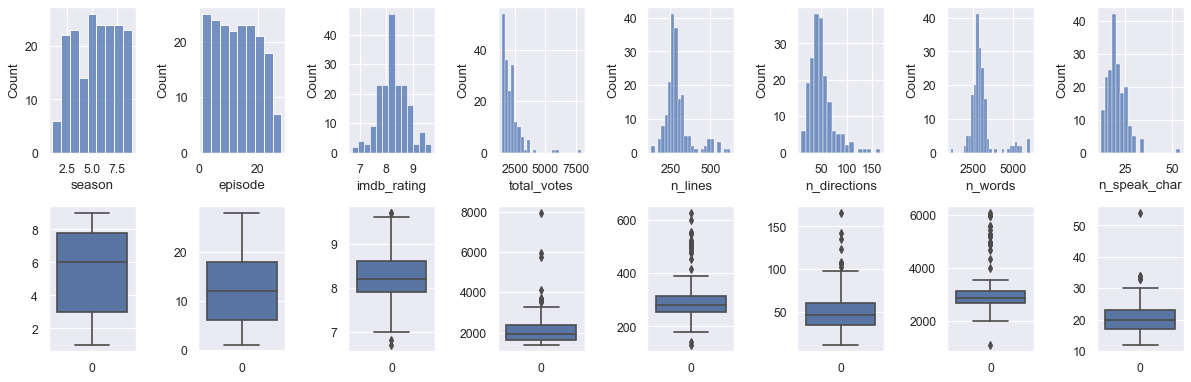

----- Unique Values -----
season has 9 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9]

episode has 28 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

episode_name has 186 unique values.
First 3: ['A Benihana Christmas (Parts 1&2)', 'A.A.R.M', 'After Hours']
Last 3: ["Women's Appreciation", 'Work Bus', 's*x Ed']

director has 61 unique values: ['Alex Hardcastle', 'Amy Heckerling', 'Asaad Kelada', 'B.J. Novak', 'Brent Forrester', 'Brian Baumgartner', 'Bryan Cranston', 'Bryan Gordon', 'Charles McDougal', 'Charles McDougall', 'Charlie Grandy', 'Claire Scanlon', 'Claire Scanlong', 'Craig Zisk', 'Daniel Chun', 'Danny Leiner', 'David Rogers', 'Dean Holland', 'Dennie Gordon', 'Ed Helms', 'Eric Appel', 'Gene Stupnitsky;Lee Eisenberg', 'Greg Daneils', 'Greg Daniels', 'Harold Ramis', 'J.J. Abrams', 'Jason Reitman', 'Jeffrey Blitz', 'Jennifer Celotta', 'Jesse Peretz', 'John Krasinski', 'John Scott', 'Jon Favreau', 'Joss Whedon', '

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
5,1,6,Hot Girl,Amy Heckerling,Mindy Kaling,7.8,2852,2005-04-26,346,39,3028,13,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Ryan...
6,2,1,The Dundies,Greg Daniels,Mindy Kaling,8.7,3213,2005-09-20,256,59,2812,20,Angela;Darryl;Dwight;Jim;Kelly;Kevin;Michael;O...
7,2,2,Sexual Harassment,Ken Kwapis,B.J. Novak,8.2,2736,2005-09-27,283,35,3064,26,Angela;Darryl;Dwight;Jim;Kevin;Meredith;Michae...
8,2,3,Office Olympics,Paul Feig,Michael Schur,8.4,2742,2005-10-04,281,33,2604,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
9,2,4,The Fire,Ken Kwapis,B.J. Novak,8.4,2713,2005-10-11,319,34,2766,16,Angela;Dwight;Jim;Kelly;Kevin;Meredith;Michael...


In [4]:
describe_data(data)

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    188 non-null    int64  
 1   Season        188 non-null    int64  
 2   EpisodeTitle  188 non-null    object 
 3   About         188 non-null    object 
 4   Ratings       188 non-null    float64
 5   Votes         188 non-null    int64  
 6   Viewership    188 non-null    float64
 7   Duration      188 non-null    int64  
 8   Date          188 non-null    object 
 9   GuestStars    29 non-null     object 
 10  Director      188 non-null    object 
 11  Writers       188 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 17.8+ KB


None

----- Descriptive Statistics -----


,Unnamed: 0,Season,Ratings,Votes,Viewership,Duration
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,93.500000,5.468085,8.237234,2838.228723,7.246330,27.053191
std,54.415071,2.386245,0.589930,1063.165290,2.066012,6.937254
min,0.000000,1.000000,6.600000,1832.000000,3.250000,19.000000
25%,46.750000,3.000000,7.800000,2187.750000,5.990000,22.000000
50%,93.500000,6.000000,8.200000,2614.000000,7.535000,23.000000
75%,140.250000,7.250000,8.600000,3144.250000,8.425000,30.000000
max,187.000000,9.000000,9.800000,10515.000000,22.910000,60.000000


----- Histogram & Boxplot -----


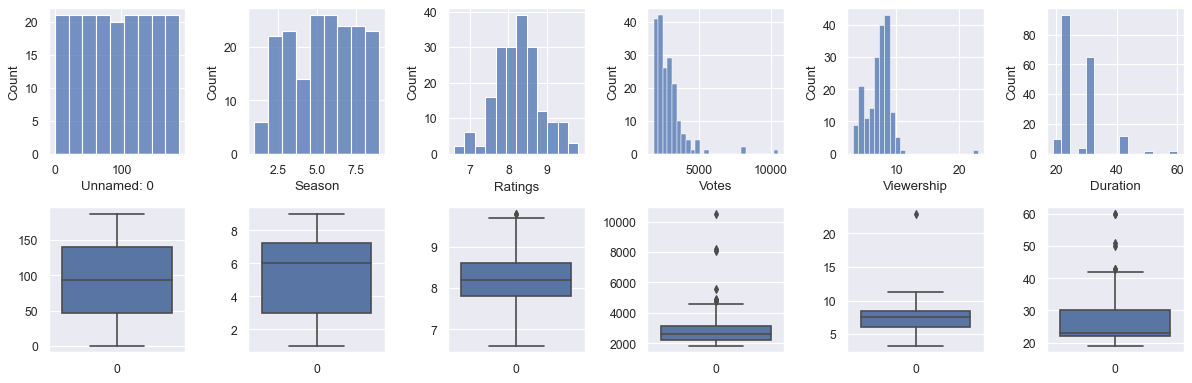

----- Unique Values -----
Unnamed: 0 has 188 unique values.
First 3: [0, 1, 2]
Last 3: [185, 186, 187]

Season has 9 unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9]

EpisodeTitle has 188 unique values.
First 3: ['A Benihana Christmas', 'A.A.R.M.', 'After Hours']
Last 3: ['Whistleblower', "Women's Appreciation", 'Work Bus']

About has 188 unique values.
First 3: ['A banker representing a potential buyer comes to the Scranton branch to interview the H.R. department before the sale goes through.', 'A confession at an H.R. business ethics seminar leads to a dispute between Michael and Holly over whether Meredith should be fired. Dwight tries to prove to Jim how long he can go without taking a personal break.', 'A fire in the kitchen relegates the staff to the parking lot as help is on its way.']
Last 3: ["While on lecture tour to other Dunder Mifflin branches, Michael and Pam discover that Jim's ex-girlfriend Karen is pregnant. At the office, Andy falls for a prospective client, and Jim and Dwi

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
0,0,1,Pilot,The premiere episode introduces the boss and s...,7.5,4936,11.20,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels
1,1,1,Diversity Day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.00,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak
2,2,1,Health Care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.80,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein
3,3,1,The Alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.40,23,12 April 2005,NaN,Bryan Gordon,Michael Schur
4,4,1,Basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.00,23,19 April 2005,NaN,Greg Daniels,Greg Daniels
5,5,1,Hot Girl,Michael is just one of the many male staff who...,7.7,3854,4.80,23,26 April 2005,Amy Adams,Amy Heckerling,Mindy Kaling
6,6,2,The Dundies,"Very much unlike his staff, an overeager Micha...",8.7,4315,9.00,21,20 September 2005,NaN,Greg Daniels,Mindy Kaling
7,7,2,Sexual Harassment,The office reviews its sexual harassment polic...,8.2,3665,7.13,22,27 September 2005,NaN,Ken Kwapis,B. J. Novak
8,8,2,Office Olympics,"Ready to finalize his deal for a new condo, Mi...",8.4,3665,8.30,22,4 October 2005,Nancy Carell,Paul Feig,Michael Schur
9,9,2,The Fire,A fire in the kitchen relegates the staff to t...,8.4,3607,7.60,22,11 October 2005,Amy Adams,Ken Kwapis,B. J. Novak


In [5]:
describe_data(data_guest_star)

From the above information, it can be concluded that:
1. **data**
    > - **director** column has typos, e.g.: "Claire Scanlon" and "Claire Scanlong" and can be more than 1 person.
    > - **air_date** column datatype is string instead of datetime.
    > - **writer** can be more than 1 person. The column uses ";" as separator.
    > - **main_chars** are more than 1 person. The column uses ";" as separator.
<br><br>
2. **data_guest_star**
    > - **Unnamed:0** column indicates the row number and can be dropped.
    > - **GuestStars** column has null values and can be more than 1 person.
    > - **EpisodeTitle** column has slightly different values compared to **episode_name** in **data**. For example, for episode 2, episode 10, **EpisodeTitle** is "Boys and Girls" instead of "Boys & Girls" (in **data**).
    > - has more rows than **data** because episode "The Delivery" is separated into 2 parts

### 2.2. Data Cleaning
This subsection performs the following tasks:
1. **data**
    > - Fixing typo in **director** column by using `get_correct_name` function.
    > - Parse **director**, **writer**, and **main_chars** as list instead of string.
    > - Remove outlier in **total_votes** using `iqr` function.
<br><br>
2. **data_guest_star**
    > - Modify the content of **EpisodeTitle** to follow **episode_name** by using `get_correct_name` function, then take the average of "The Delivery" episode.
    > - Impute null values and parse **GuestStar** as list instead of string.
    > - Remove irrelevant columns.
    > - Remove outlier in **viewership** using `iqr` function.

In [6]:
def get_correct_name(list_incorrect_words, list_correct_words):
    """
    Search for the closest match in list_correct_words to replace the incorrect word.
    This function utilizes regex and get_close_matches from difflib library.
    Reference: https://docs.python.org/3/library/difflib.html
    
    Parameters
    ----------
    list_incorrect_words: a sequence of incorrect words that needs to be replaced (list).
    list_correct_words: a sequence of correct words that will be used as the reference (list).
    
    Raises
    ------
    KeyError if either list_incorrect_words or list_correct_words is null.
    
    Returns
    -------
    corrected_words: a sequence of corrected words based on list_correct_words (pd.Series). 
    """
    
    # Raising errors if data is empty
    if len(list_incorrect_words) == 0:
        raise KeyError(f'List of incorrect words is empty.')
    elif len(list_correct_words) == 0:
        raise KeyError(f'List of correct words is empty.')
    
    list_corrected_words = []
    for word in list_incorrect_words:
        # Use regex to search whether the correct word starts with incorrect word.
        # E.g., incorrect: The Job, correct: The Job (Part 1 & 2)
        r = re.compile(f'^{word}')
        corrected_word = list(filter(r.match, list_correct_words))
        
        if len(corrected_word) != 0:
            list_corrected_words.append(corrected_word[0])
        else:
            # Find the best match using get_close_matches
            list_corrected_words.append(get_close_matches(word, list_correct_words, cutoff=0.6, n=1)[0])
        
    return list_corrected_words

In [7]:
def iqr(data):
    """
    Returns lower_bound and upper_bound from statistical method for outlier removal.
    
    Parameters
    ----------
    data: raw data of a numerical column (pd.Series)
    
    Raises
    ------
    KeyError raised if:
        - Series is empty
        - data is not numerical
    """
    
    # Raising errors if series is empty
    if len(data) == 0:
        raise KeyError(f'Series is empty')
        
    if not np.issubdtype(data, np.number):
         raise KeyError(f'Data is not numerical')
    
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    
    if lower_bound < 0:
        lower_bound = np.percentile(data, 5)
    
    upper_bound = q3 + 1.5 * iqr
    
    return lower_bound, upper_bound

Text(0.5, 0, 'Viewership')

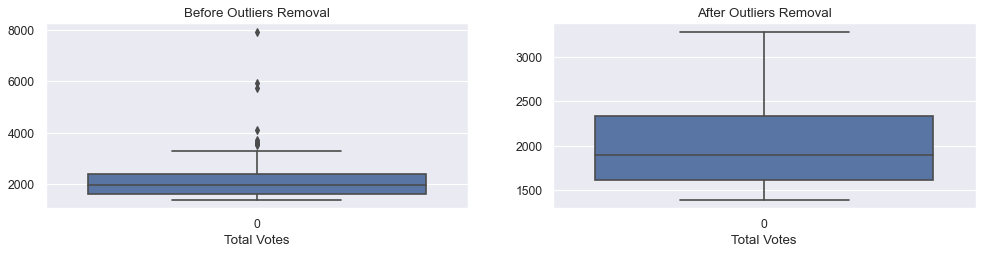

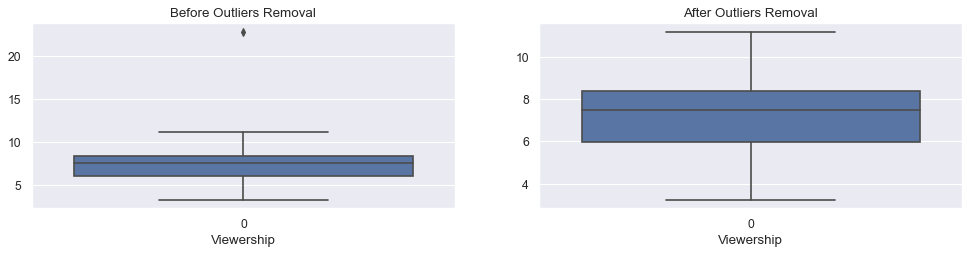

In [8]:
# 1. data
# Fixing typo in director column
typo_director = ['Charles McDougal', 'Claire Scanlong', 'Greg Daneils', 'Ken Wittingham', 'Paul Lieerstein']
data_cleaned = data.copy().rename(columns={'director':'director_old'})
data_cleaned.loc[:, 'director'] = get_correct_name(data_cleaned['director_old'].values,
                                                   list(filter(lambda x: x not in typo_director, data['director'])))
data_cleaned = data_cleaned.drop(columns='director_old')

# Parse director, writer, and main_chars as list 
for col in ['director', 'writer', 'main_chars']:
    data_cleaned[col] = data_cleaned[col].str.split(';')
    
# Remove outliers in total_votes using iqr_method
fig, ax = plt.subplots(1, 2, figsize=(15,3))
sns.boxplot(data_cleaned['total_votes'], ax=ax[0])
ax[0].set_title('Before Outliers Removal')
ax[0].set_xlabel('Total Votes')

lower_bound, upper_bound = iqr(data_cleaned['total_votes'])
data_cleaned = data_cleaned[data_cleaned['total_votes'] <= upper_bound].copy().reset_index(drop=True)
sns.boxplot(data_cleaned['total_votes'], ax=ax[1])
ax[1].set_title('After Outliers Removal')
ax[1].set_xlabel('Total Votes')

# 2. data_guest_star
# Modify EpisodeTitle to follow episode_name column
data_guest_star_cleaned = data_guest_star.copy().rename(columns={'EpisodeTitle':'EpisodeTitle_old'})
data_guest_star_cleaned['EpisodeTitle'] = get_correct_name(data_guest_star_cleaned['EpisodeTitle_old'].values, data['episode_name'].values)

# Impute null values in GuestStars as 'N/A'
data_guest_star_cleaned['GuestStars'] = data_guest_star_cleaned['GuestStars'].fillna('null')

# Remove irrelevant columns and take the average of "The Episode" column
data_guest_star_cleaned = data_guest_star_cleaned.groupby(['Season', 'EpisodeTitle'], as_index=False).agg({'GuestStars':'min', 'Viewership':'mean', 'Duration':'mean'})

# Parse as list
data_guest_star_cleaned['GuestStars'] = data_guest_star_cleaned['GuestStars'].str.split(',')

# Standardize column name
data_guest_star_cleaned.columns = data_guest_star_cleaned.columns.str.lower()
data_guest_star_cleaned = data_guest_star_cleaned.rename(columns={'gueststars':'guest_stars', 'episodetitle':'episode_name'})

# Remove outliers in viewership using iqr_method
fig, ax = plt.subplots(1, 2, figsize=(15,3))
sns.boxplot(data_guest_star_cleaned['viewership'], ax=ax[0])
ax[0].set_title('Before Outliers Removal')
ax[0].set_xlabel('Viewership')

lower_bound, upper_bound = iqr(data_guest_star_cleaned['viewership'])
data_guest_star_cleaned = data_guest_star_cleaned[data_guest_star_cleaned['viewership'] <= upper_bound].copy().reset_index(drop=True)
sns.boxplot(data_guest_star_cleaned['viewership'], ax=ax[1])
ax[1].set_title('After Outliers Removal')
ax[1].set_xlabel('Viewership')

### 2.3. Correlation
In this subsection, a deeper analysis about the correlation between the variables is provided.

In [9]:
def get_correlation(df):
    """
    Depicts pairwise plot and Spearman correlation matrix between numerical variables.
    
    Parameters
    ----------
    df: cleaned data that is going to be analyzed (pd.DataFrame).
    """
    
    # Pairwise plot
    sns.pairplot(df)
    
    # Phik correlation matrix
    plt.figure()
    sns.heatmap(df.corr(method='spearman'), annot=True)

In [10]:
# Merge data based on season and episode_name
df = data_cleaned.merge(data_guest_star_cleaned, how='inner', on=['season', 'episode_name'])
df = df.drop(columns=['season', 'episode'])

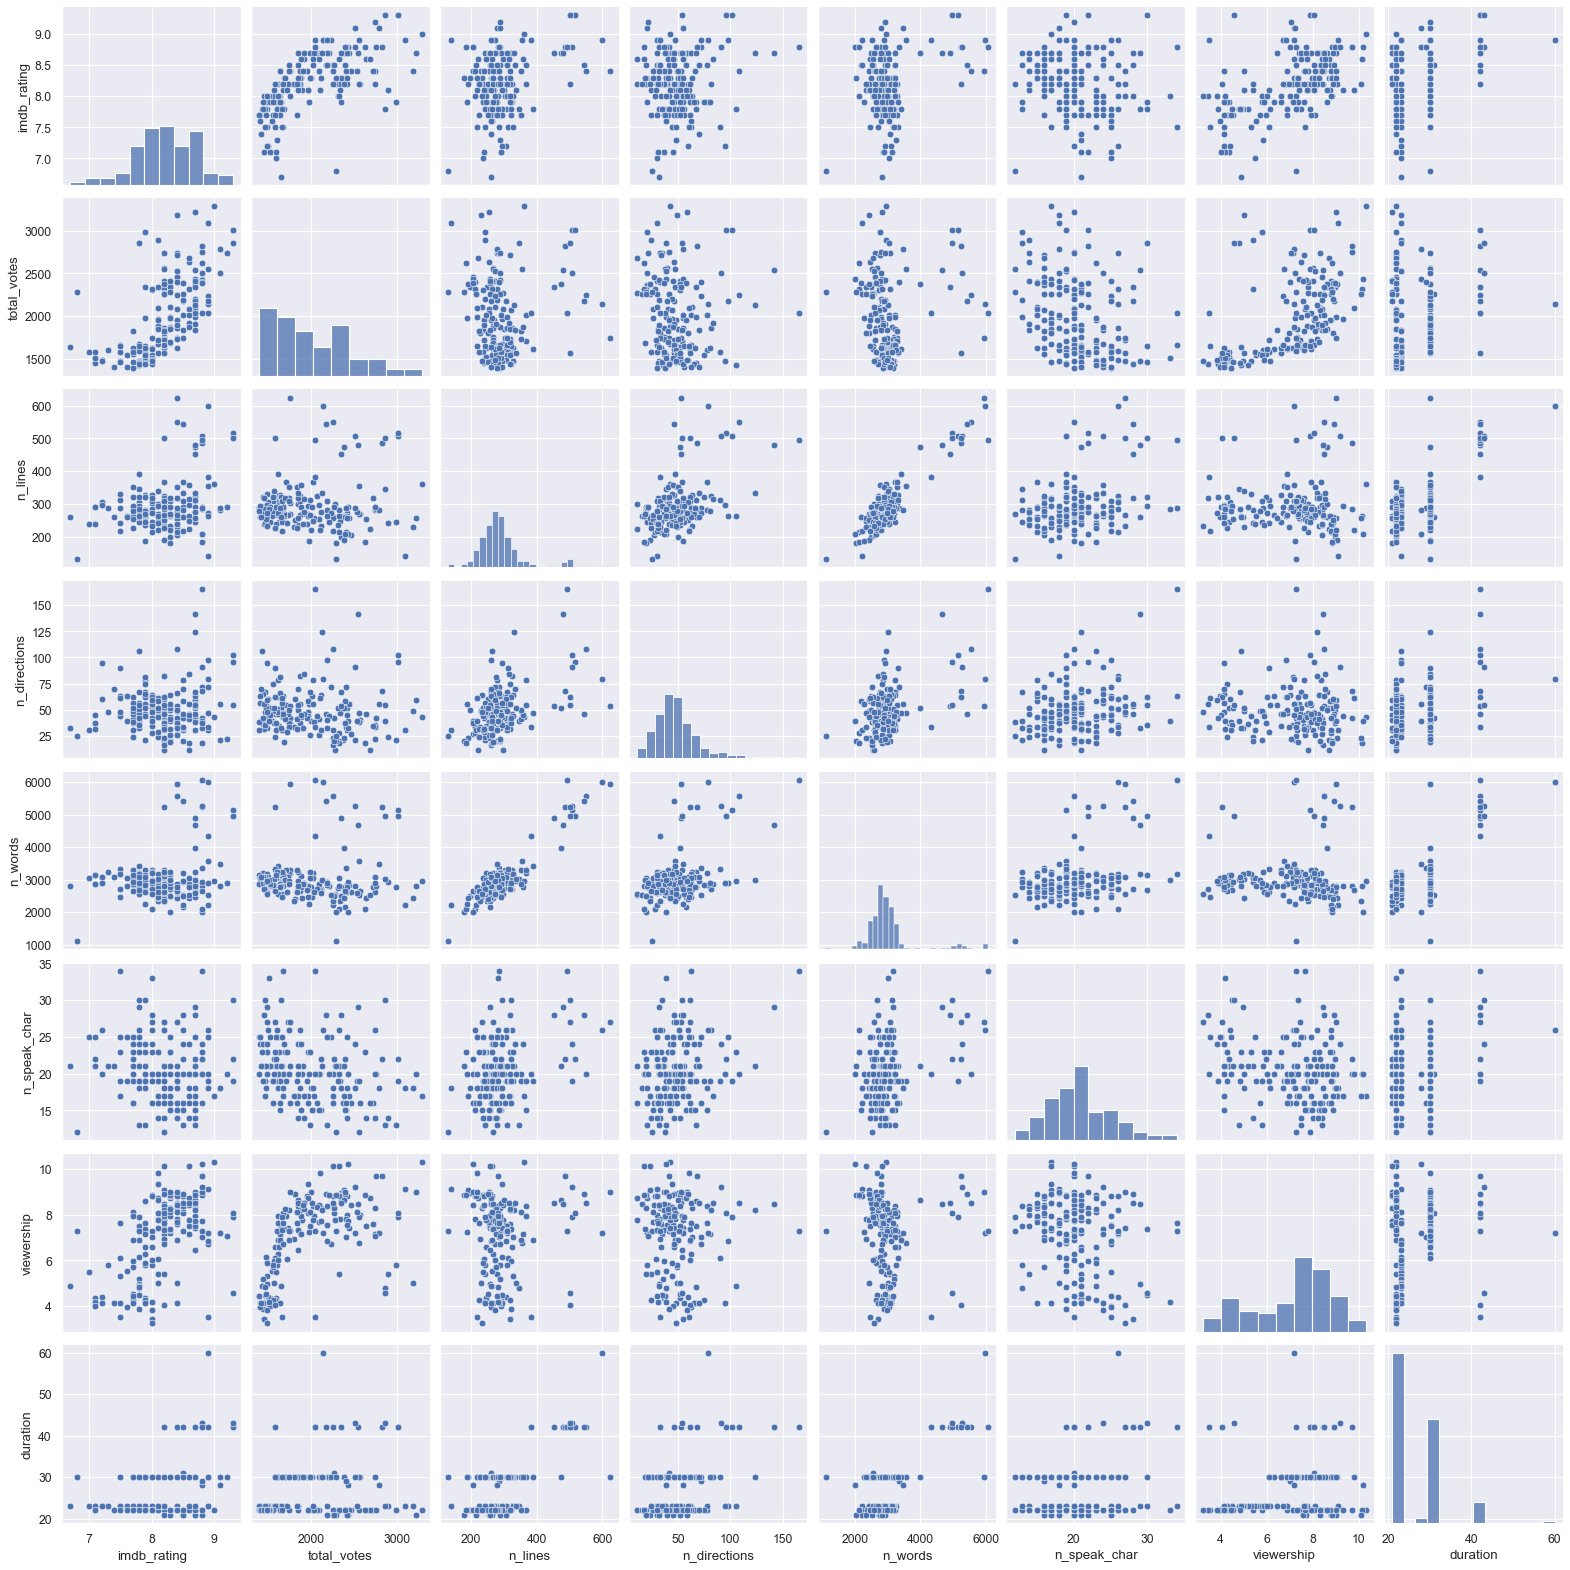

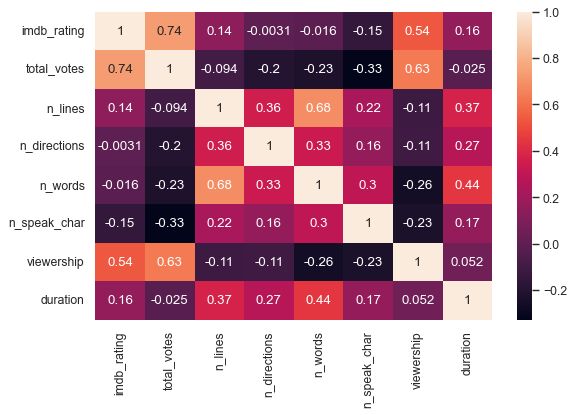

In [11]:
# Show pairwise plot and correlation matrix
get_correlation(df)

Based on the above graphs, there are several key takeaways as follows:
> - There is a very strong relationship between imdb_rating and total_votes. Additionally, there is a strong relationship between imdb_rating and viewership.
> - There is strong relationship between total_votes and viewership.
> - There is a very strong relationship between n_lines and n_words.
> - There is strong relationship between n_words and duration.

<img src="spearman_interpretation.png" width=600>

### 2.4. Feature Extraction
In this part, relevant new features are developed and features that are highly correlated or have low variance are removed.
The abovementioned features are described as follows:
1. xx 
2. xx
3. xx

In [12]:
def extract_feature(df, data):
    """
    Generate additional features as follows:
    (1) Number of writers, main characters, and guest stars for each episode
    (2) Rating from previous episode
    (3) length of episode name
    (4) mean, minimum, and maximum rating that has been obtained by writers, director(s), and main characters
    
    Parameters
    ----------
    df: existing dataframe (pd.DataFrame).
    data: existing raw data (pd.DataFrame).
    
    Raises
    ------
    KeyError if any of these columns does not exist:
        - writer
        - director
        - main_chars
        - guest_stars
        - imdb_rating
        - episode_name
        - air_date
    
    Returns
    -------
    df: existing dataframe with additional features (pd.DataFrame).
    """
    
    # Raising errors if any of the required columns does not exist
    for col in ['writer', 'director', 'main_chars', 'guest_stars', 'imdb_rating', 'episode_name', 'air_date']:
        if not col in df.columns:
            raise KeyError(f'Dataframe does not contain {col} column.')  

    # Count the number of writer, main_chars, and guest_stars
    for col in ['writer', 'main_chars', 'guest_stars']:
        df[col + '_count'] = df[col].apply(lambda x: len(x) if x[0] != 'null' else 0)

    # Rating and total_votes from previous episode
    df['imdb_rating_prev'] = df['imdb_rating'].shift(1)

    # Length of each episode name
    df['episode_name_length'] = df['episode_name'].str.len()

    # Retrieve mean_rating, max_rating, and min_rating from writer, director, and main_chars
    dictionary = {'writer': pd.DataFrame(), 'director': pd.DataFrame(), 'main_chars': pd.DataFrame()}
    for col in dictionary.keys():
        dictionary[col] = (data.set_index(['air_date', 'imdb_rating']) \
                           [col].str.split(';\s*', expand=True) \
                           .stack() \
                           .reset_index() \
                           .drop(columns='level_2') \
                           .pivot_table(index=['air_date'], columns=0))
        dictionary[col] = dictionary[col]['imdb_rating'].reset_index()

        df[col + '_mean_rating'] = df.apply(lambda x: np.nanmean(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])),
                                            axis=1)
        df[col + '_min_rating'] = df.apply(lambda x: np.nanmin(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                           if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                            axis=1)
        df[col + '_max_rating'] = df.apply(lambda x: np.nanmax(np.matrix(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]])) \
                                           if len(dictionary[col][dictionary[col]['air_date'] < x['air_date']][x[col]]) != 0 else 0,
                                            axis=1)

    return df

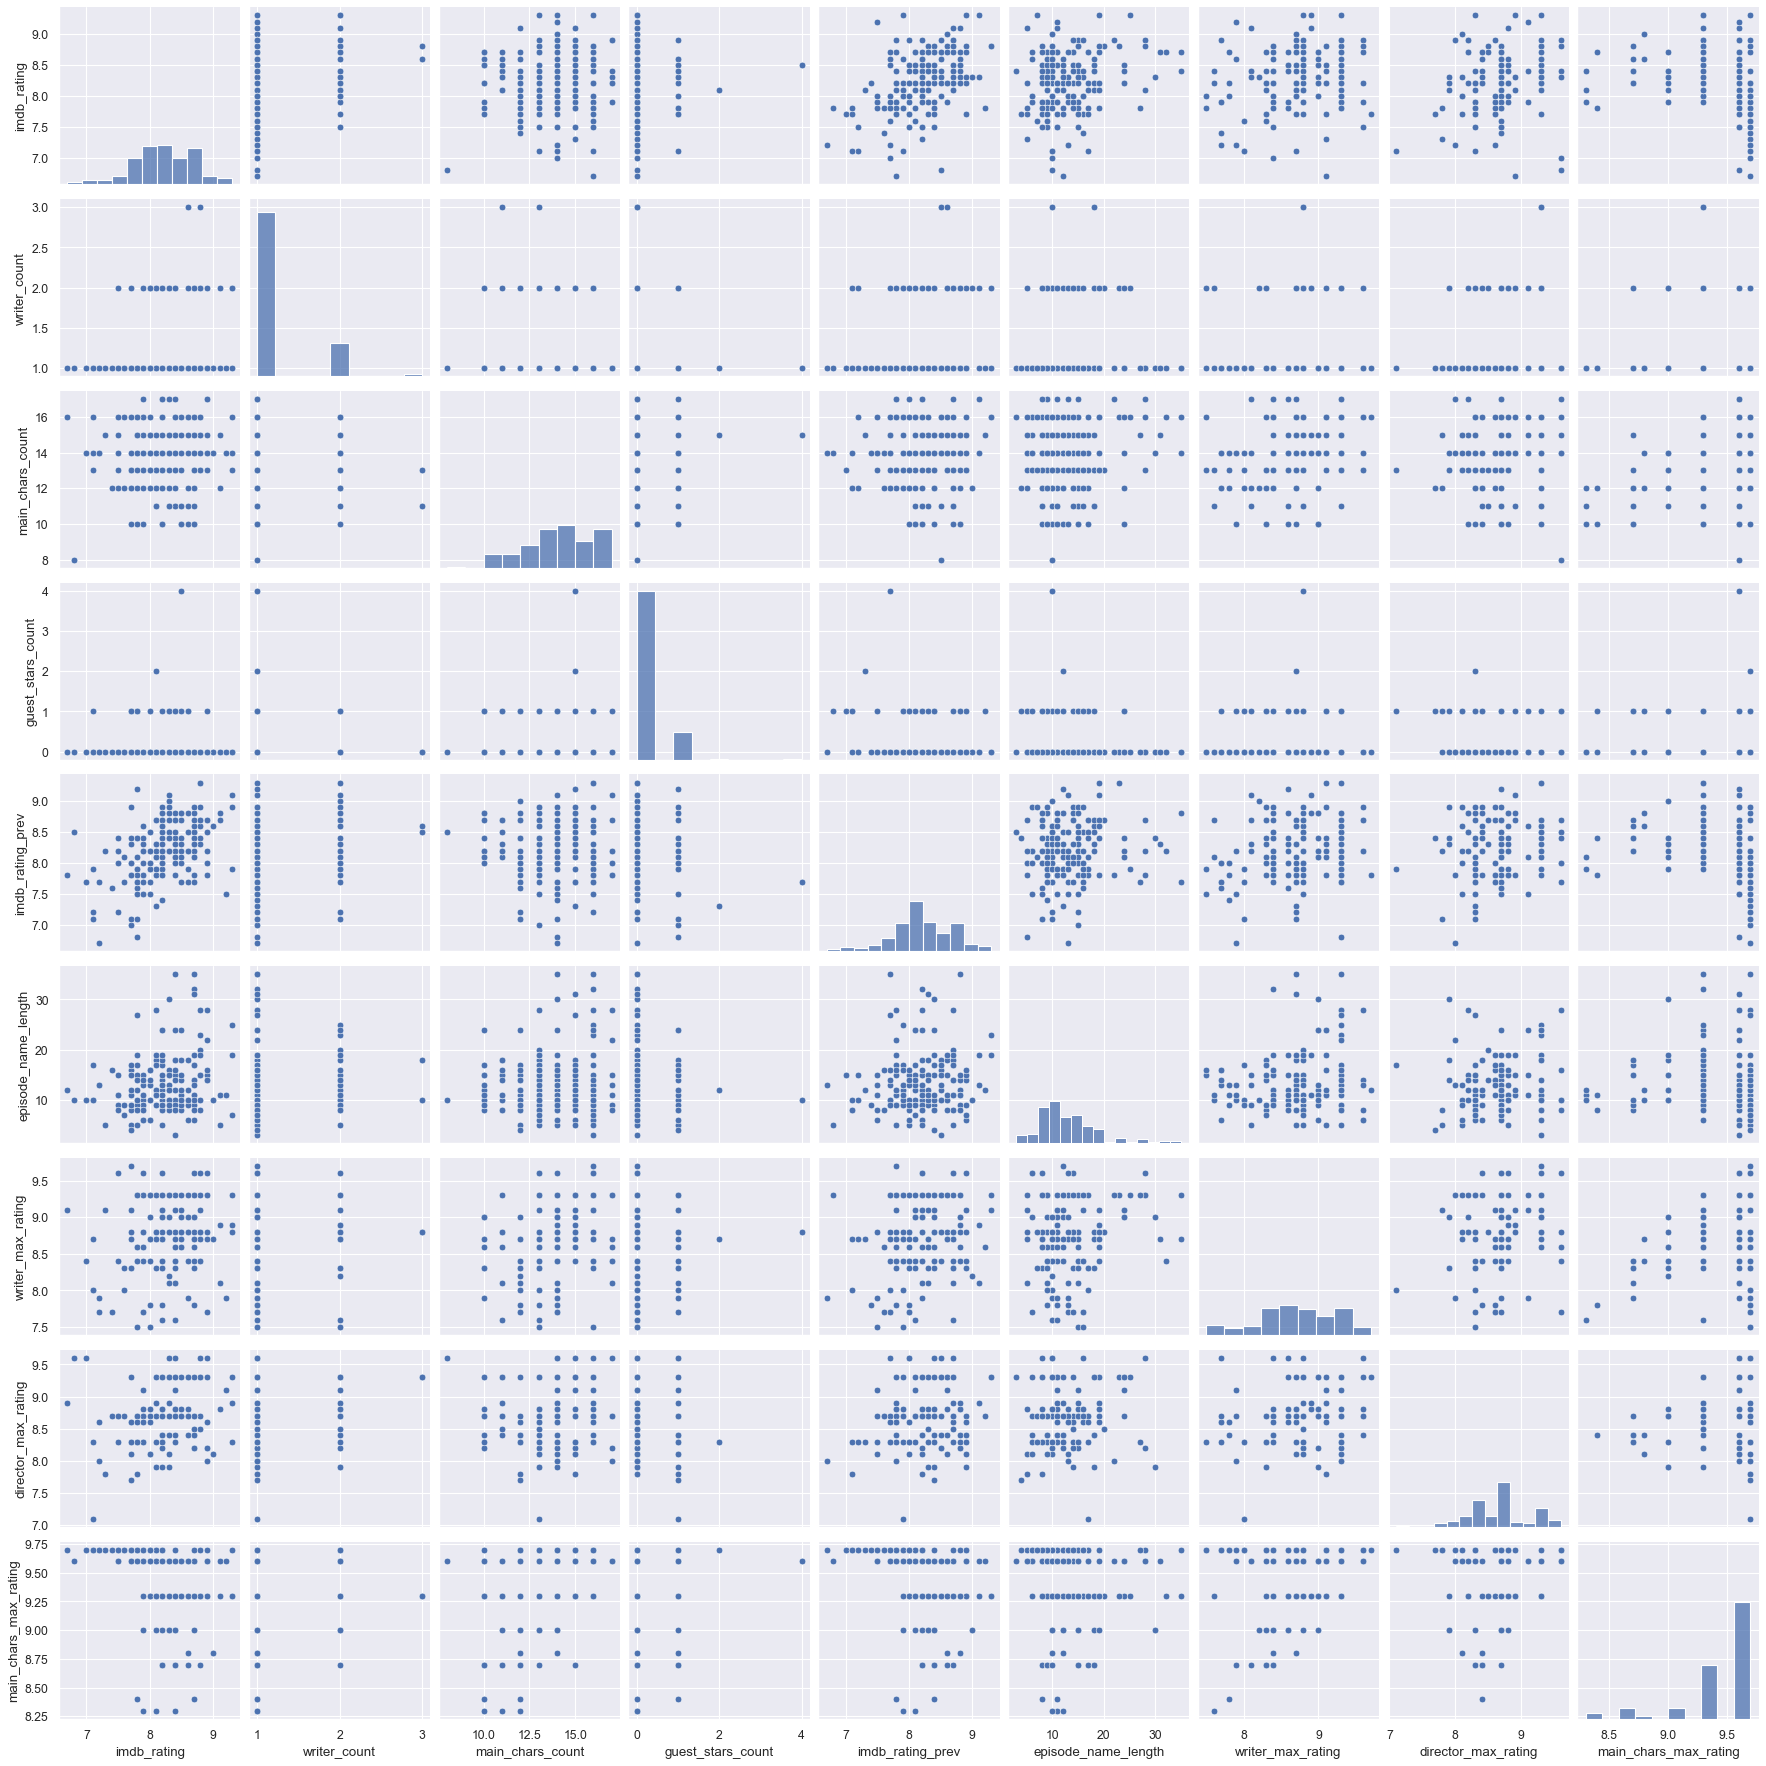

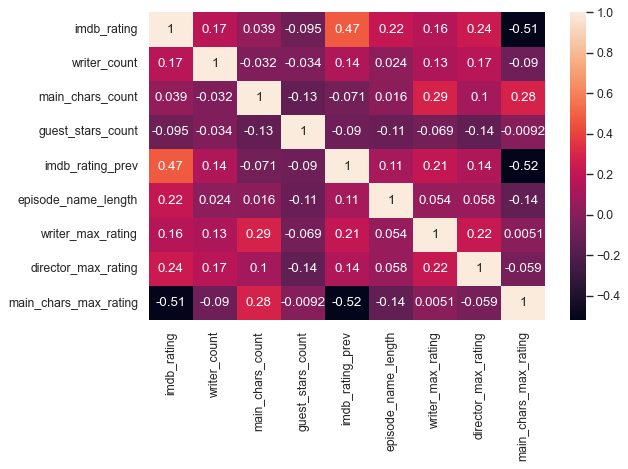

In [13]:
df = extract_feature(df, data)
get_correlation(df[['imdb_rating', 'writer_count',
                   'main_chars_count', 'guest_stars_count', 'imdb_rating_prev',
                   'episode_name_length', 'writer_max_rating',
                   'director_max_rating', 'main_chars_max_rating']])

In [14]:
# Top 50 TV Episode, Rating Count at least 1,000
url = 'https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=1000,&sort=user_rating,desc'
# Top 50 TV Episode, Rating Count at least 10,000
url2= 'https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=10000,&sort=user_rating,desc'
# Top 50 TV Episode
url3= 'https://www.imdb.com/list/ls058613627/'

def get_all_names(urls):
    episode_name,series_name=[],[]
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for h in soup.find_all('small', {'class': 'text-primary unbold'}):
            if h:
                episode_name.append(h.find_next_sibling('a').text)
        for h in soup.find_all('span', {'class': 'lister-item-index unbold text-primary'}):
            hh=h.find_next_sibling('a')
            if hh:
                series_name.append(hh.text)
    series_name=list(set(series_name))
    episode_name=list(set(episode_name))
    return episode_name,series_name

get_all_names((url,url2,url3))

(["Wilson's Heart",
  'Confessions',
  'Crawl Space',
  'Lazarus',
  'Goodbye, Michael',
  'Kotae o Sagashite: Hiken Ace Senjou ni Shisu',
  'Vichnaya Pamyat',
  'Finale',
  'Re;',
  'Tome-wan',
  'A Fistful of Paintballs',
  "Sozin's Comet, Part 4: Avatar Aang",
  'Baelor',
  'Memories of the Future',
  'One Minute',
  'That Day',
  'How Your Mother Met Me',
  'Too Far Gone',
  'Granite State',
  'The Lion and the Rose',
  'If-Then-Else',
  'Chapter 14',
  'A Scandal in Belgravia',
  'Zero × and × Rose',
  'Kejime o Tsukeru: Shirohige vs Kurohige Kaizokudan',
  "Yu Ishigami Closes His Eyes, Part 3/Miyuki Shirogane and Yu Ishigami/Kyoko Otomo Doesn't Realize",
  'Sleepytime',
  'Perfect Game',
  'Through the Looking Glass: Part 1',
  'My Finale: Part 2',
  'Victory and Death',
  'Once More, with Feeling',
  'Blackwater',
  'And Now His Watch Is Ended',
  'My Screwup',
  "Sozin's Comet, Part 3: Into the Inferno",
  'The Soup Nazi',
  'Riddled',
  'Remedial Chaos Theory',
  'Say My Name'

### 2.5. Feature Scaling
XXX

In [15]:
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """
    Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`.
    Note that input X has to be a `pandas.DataFrame`.
    """
    
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.labels = list()

    def fit(self, X:pd.DataFrame, y=None):
        for col in X.columns: # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.loc[:,col])
            self.mlbs.append(mlb)
            self.labels.append([col[0] + '_' + x for x in mlb.classes_])
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result
    
    def get_feature_names(self):
        return self.labels

In [16]:
def preprocess(model, num_cols, cat_cols):
    """
    Scale numerical columns and encode categorical columns.
    
    Parameters
    ----------
    model: machine learning model (sklearn model).
    num_cols: numerical columns that are going to be scaled (list).
    cat_cols: categorical columns that are going to be encoded (list).
    
    Returns
    -------
    df_pre: dataframe with new values (pd.DataFrame).
    """
    
    num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('num_scale', StandardScaler()),
    ('num_transform', PowerTransformer(method='yeo-johnson'))
    ])
    
    cat_pipe = Pipeline([
    ('cat_encode', MultiHotEncoder())
    ])
    
    pipeline = Pipeline([
        ('pre-processing', ColumnTransformer([
            ('num_cols', num_pipe, num_cols),
            ('cat_cols', cat_pipe, cat_cols)])),
        ('model', model)
    ])

    return pipeline

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [17]:
def split(df):
    """
    Split data to training and testing.

    Parameters
    ----------
    df: Pandas dataframe of data to be modeled (pd.DataFrame).
    
    Returns
    -------
    X_train: Training dataset (pd.DataFrame).
    X_test: Testing dataset (pd.DataFrame).
    y_train: Training label (pd.Series).
    y_test: Testing label (pd.Series)
    """
    
    X = df.drop(columns=['imdb_rating'])
    y = df['imdb_rating']
    
    # Split out the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [18]:
def model_fit(pipeline, X_train, X_test, y_train, y_test):
    """
    Train model with hyperparameter tuning using GridSearchCV to identify the best parameters
    and evaluate the model performance using R2, RMSE, and MAE.
    
    Parameters
    ----------
    pipeline: sklearn pipeline
    X_train: Training dataset (pd.DataFrame).
    X_test: Testing dataset (pd.DataFrame).
    y_train: Training label (pd.Series).
    y_test: Testing label (pd.Series)
    
    Returns
    -------
    best_estimator: Model with best parameter (sklearn model).
    """
    
    from IPython.utils import io
  
    # Run model
    # Randomized search of parameters, using 3 fold cross validation
    params = {'model__n_estimators': range(100, 200, 10)
             }
    
    model = GridSearchCV(pipeline, param_grid=params, scoring='r2', cv=3, verbose=0, n_jobs=-1)

    # Fit the randomized search model
    with io.capture_output() as captured:
        model.fit(X_train, y_train)
    best_estimator = model.best_estimator_
    print('Best Parameters: {}'.format(model.best_params_))
    pred_train = best_estimator.predict(X_train)
    print('R2 Score (Train): {}'.format(r2_score(y_train, pred_train)))

    # Evaluation metrics
    pred_test = best_estimator.predict(X_test)
    print('R2 Score: {}'.format(r2_score(y_test, pred_test)))
    print('RMSE: {}'.format(mean_squared_error(y_test, pred_test, squared=False)))
    print('MAE: {}'.format(mean_absolute_error(y_test, pred_test)))

    # Plot R2 Score
    plt.figure(figsize=(11, 5))
    
    # Train
    plt.subplot(121)
    plt.scatter(pred_train, y_train, c='r', s=10)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--', zorder=-1)
    plt.xlabel("Prediction", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title(f"R2_train: {r2_score(y_train, pred_train):.3f}", fontsize=14)
    
    # Test
    plt.subplot(122)
    plt.scatter(pred_test, y_test, c='r', s=10)
    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    lim = min(x1, y1), min(x2, y2)
    plt.xlim(*lim)
    plt.ylim(*lim)
    plt.plot(lim, lim, 'k--', zorder=-1)
    plt.xlabel("Prediction", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title(f"R2_test: {r2_score(y_test, pred_test):.3f}", fontsize=14)
    
    # Plot residual
    plt.figure(figsize=(15, 5))
    
    # Train
    plt.subplot(121)
    sns.residplot(x=model.predict(X_train), y=y_train, scatter_kws={'s': 10, 'color': 'b'})
    plt.xlabel("Prediction", fontsize=14)
    plt.ylabel("Residual", fontsize=14)
    plt.title("Train")

    # Test
    plt.subplot(122)
    sns.residplot(x=model.predict(X_test), y=y_test, scatter_kws={'s': 10, 'color': 'b'})
    plt.xlabel("Prediction", fontsize=14)
    plt.ylabel("Residual", fontsize=14)
    plt.title("Test");
  
    return best_estimator

In [19]:
def show_feature_importances(pipeline, num_cols, topk=10):
    """
    Depicts feature importances based on Random Forest Regressor model.
    
    Parameters
    ----------
    xx
    xx
    
    """
    colors = sns.light_palette('seagreen', topk, reverse=True)
    
    feature_names = num_cols.copy()
    for array in pipeline['pre-processing'].transformers_[1][1]['cat_encode'].get_feature_names():
        feature_names.extend(array)
    df_feature = pd.DataFrame({'name': feature_names,
                               'importance': pipeline['model'].feature_importances_}).sort_values('importance', ascending=False)
    
    if topk:
        df_feature = df_feature.head(topk)
    
    # Plot
    plt.figure(figsize=(15, 5))
    sns.barplot(df_feature, x='importance', y='name', palette=colors)
    plt.title('Feature Importances', fontsize=14)

In [20]:
def show_msd(pipeline, normalize=True, topk=10):
    """
    Calculate mean score decrease of each feature.
    Mean score decrease perform a random permutation on each of the input columns then collects the score decrease caused by each columns.
  
    Parameters
    ----------
    pipeline: sklearn pipeline.
    """
    
    colors = sns.light_palette('#79C', topk)
      
    imp = permutation_importance(pipeline, X_train, y_train, n_repeats=5, n_jobs=1, random_state=42)

    df_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': imp['importances_mean'],
        'stdev': imp['importances_std']
    }).sort_values('importance', ascending=False)

    if normalize:
        df_imp[['importance', 'stdev']] = df_imp[['importance', 'stdev']] / df_imp.importance.sum()

    if topk:
        df_imp = df_imp.head(topk)
        
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(df_imp)), df_imp.importance, yerr=df_imp.stdev, color='c', error_kw={"capsize": 5})
    plt.xticks(range(len(df_imp)), df_imp.feature, rotation=45, horizontalalignment='right')
    plt.ylabel('Importance')
    plt.title('Mean Score Decrease', fontsize=14);

/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Allison Silverman', 'Caroline Williams', 'Daniel Chun', 'Jason Kessler', 'Jonathan Huges', 'Larry Willmore'] will be ignored
  warnings.warn(
/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Brian Baumgartner', 'Eric Appel', 'Kelly Cantley-Kashima', 'Roger Nygard', 'Steve Carell'] will be ignored
  warnings.warn(
/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Nancy Carell', 'Tim Meadows', 'Will Ferrell'] will be ignored
  warnings.warn(
/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Graham Wagner', 'Steve Carell'] will be ignored
  w

/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Amelie Gillette', 'Anthony Q. Farrell', 'Dan Greaney', 'Dan Sterling', 'Nicki Schwartz-Wright', 'Owen Ellickson', 'Peter Ocko', 'Ricky Gervais', 'Stephen Merchant', 'Tim McAuliffe'] will be ignored
  warnings.warn(
/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Alex Hardcastle', 'Amy Heckerling', 'Craig Zisk', 'Gene Stupnitsky', 'Harold Ramis', 'Julian Farino', 'Lee Eisenberg', 'Mindy Kaling', 'Reginald Hudlin', 'Rodman Flender', 'Tucker Gates'] will be ignored
  warnings.warn(
/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Amy Adams', 'Idris Elba', 'Julius Winfield Erving', 'Michael Imperioli ', 'Mike Starr', 'Ryan Howard', 'Stephen

/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Allison Silverman', 'Caroline Williams', 'Daniel Chun', 'Jason Kessler', 'Jonathan Huges', 'Larry Willmore'] will be ignored
  warnings.warn(
/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Brian Baumgartner', 'Eric Appel', 'Kelly Cantley-Kashima', 'Roger Nygard', 'Steve Carell'] will be ignored
  warnings.warn(
/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Nancy Carell', 'Tim Meadows', 'Will Ferrell'] will be ignored
  warnings.warn(
/Users/monica.stephanie/opt/anaconda3/envs/mlp-proj1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Amelie Gillette', 'Anthony Q. Farrell', 'Dan Greane

Best Parameters: {'model__n_estimators': 160}
R2 Score (Train): 0.9334547736118767
R2 Score: 0.6845229510116893
RMSE: 0.266471798374055
MAE: 0.21405092592592445


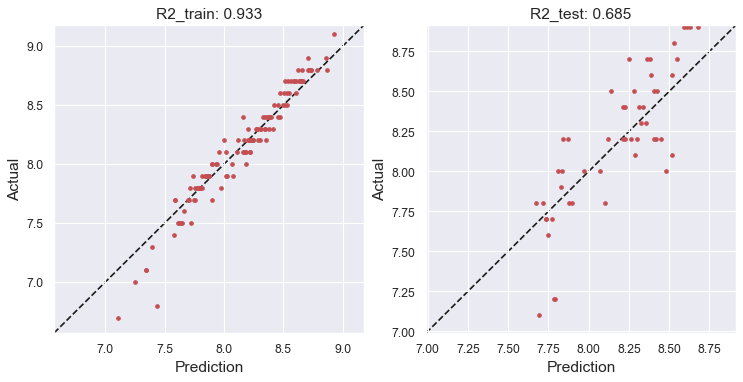

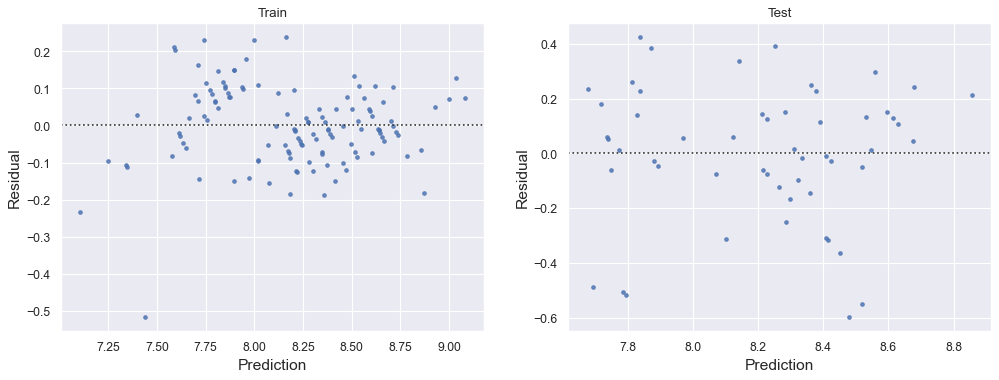

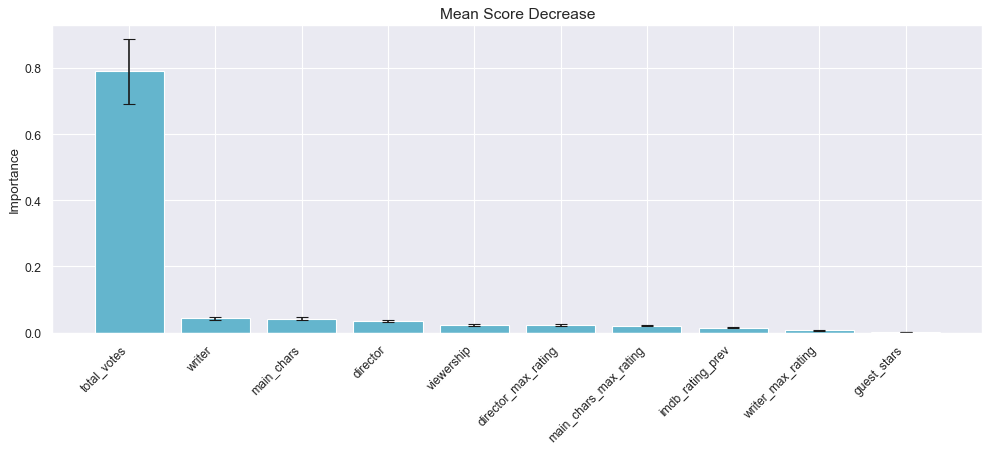

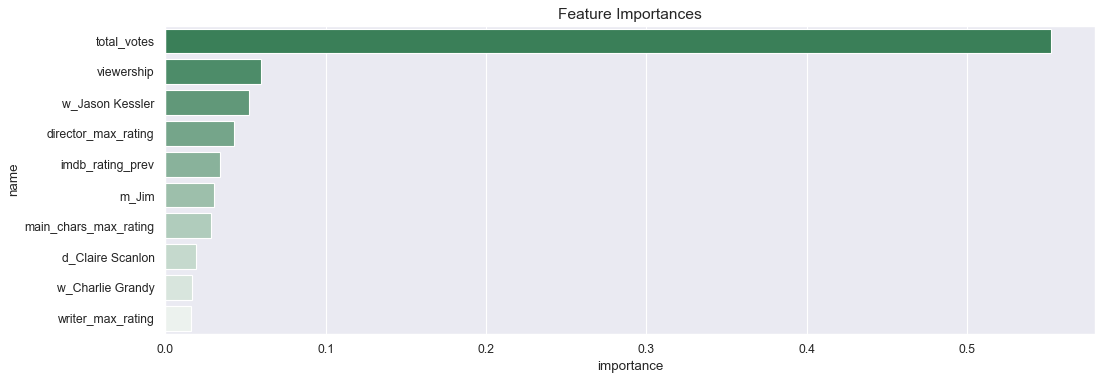

In [21]:
num_cols = ['total_votes',
            'viewership', 
            'writer_max_rating',
            'director_max_rating',
            'main_chars_max_rating',
            'imdb_rating_prev']

cat_cols = ['writer',
            'main_chars',
            'director',
            'guest_stars']

model = RandomForestRegressor(random_state=42)
pipeline = preprocess(model, num_cols, cat_cols)
X_train, X_test, y_train, y_test = split(df)
final_pipeline = model_fit(pipeline, X_train, X_test, y_train, y_test)
show_msd(final_pipeline)
show_feature_importances(final_pipeline, num_cols)

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from